# Language Models

In our pursuit of making computers understand and generate human-like text, LLM were developed.
Language modeling in general is concerned with predicting the next word in a sequence of words. One of the early and basic examples of LMs is the n-gram model, where the probability of a word occurring is calculated based on the previous n-1 words.

For example, in a 5-gram model, and the sentence "The quick brown fox jumps over the lazy dog", the probability of the word "dog" occuring is calculated based on the previous 4 words "over the lazy". This is a very simple model and does not capture the context of the sentence very well.

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2023/05/Language-Model-N-gram.jpg" />

source: https://www.baeldung.com/cs/large-language-models

## Large Language Models
The benifit of N-gram models is limited. This is where large language models (LLMs) come in. LLMs are able to capture the context of the sentence and generate more accurate predictions. They language models that use large neural networks with up to billions of parameters. They can capture more complex syntax and semantics of the human language. They can perform a number of tasks, ranging from translation, identifying offensive content, or even passing professional exams.

To further understand LLMs, we will introduce two concepts here, **embedding** and **tokenization**.

### Embeddings
You can think of embeddings as values assigned to words that represent aspects of their meaning. For example, if we want to describe objects in terms of their size and taste, a dog will score high on the size and low on the taste, while a rock will score low on both, and so on. When the model learns such values, it acquires some form of representation of word *meaning*. That is why, **embeddings are a major part of what the models are actually trained on**.

<img src="https://raw.githubusercontent.com/abdulrahman1123/analysis_examples/refs/heads/main/embeddings.png" width=400 height=423 />

### Tokenization and Encoding
Have you ever subscriped to the 'pay as you go' tier in ChatGPT, Cluade or Deepseek? If so, then you probably noticed that they calculate usage by the number of tokens. But what are tokens?
Well, they are the smallest chunks that you split your text into. Usually, they represent sub-word syllables. For example, the word "unbelievable" can consist of three tokens, "un", "believ" and "able". However, we can determine the granularity of our definition of tokens, and we can split our data on the letter level, or on the whole-word level if we want to.

Finally, we all know how computers love numbers. So, we want to convert all words to numbers before feeding them to the model for training. This is known as **encoding**. When we get the output of the machine, we convert it back to words using **decoding**.

<img src="https://raw.githubusercontent.com/abdulrahman1123/analysis_examples/refs/heads/main/tokenization.png" width=1050 height=225 />

Enough talk now. let's start coding.

-----

# Writing an LLM
### importing important functions and libraries
I created a file containing all important functions that we need. All we have to do now is clone my repository by running the following cell:

In [1]:
# Clone the repository and all its functions
!git clone https://github.com/abdulrahman1123/analysis_examples.git

# Add the cloned directory to Python path
import sys
sys.path.append('/content/analysis_examples')

# Import important functions, including functions to build the model and train it
from microGPT import *

fatal: destination path 'analysis_examples' already exists and is not an empty directory.


## Shakespeare's Work
Let's download theentirety of Shakespeare's work to train our model.

In [2]:
url1 = "https://www.gutenberg.org/cache/epub/100/pg100.txt"
text = requests.get(url1).text.replace('\r','')
text = text[text.find('THE SONNETS\n\n')::] # remove text introduction
print(f"Length of dataset in characters: {len(text)}")
print(text[:302])

Length of dataset in characters: 5376417
THE SONNETS

                    1

From fairest creatures we desire increase,
That thereby beauty’s rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed’st thy light’s flame with self-substantial fuel,


### Hyperparameters
Hyperparameters are parameters that specify how the model is built and trained. 

In [3]:

batch_size = 16 # how many independent sequences will we process in parallel
block_size = 64 # what is the maximum context length for predictions
max_iters = 1000
learning_rate = 2e-4
device = torch.device("cpu")
eval_iters = 100
eval_interval = max_iters//10
n_embd = 128
n_head = 4
n_layer = 4
n_embd = (n_embd//n_head)*n_head
dropout = 0.1
vocab_size = 10000


max_iters = 10000
learning_rate = 2e-4
device = torch.device("mps")
eval_iters = 100
eval_interval = max_iters//10
batch_size = 32
vocab_size = 20000
n_embd = 256
block_size = 256
n_head = 8
n_layer=8


### Create Tokenizer, Encoder and Decoder functions
create Tokenizer, Encoder and Decoder functions. The encoder is used to feed encoded data to the model (numbers only), and the decoder is used to convert the model's output into characters.

Vocab size: 20000


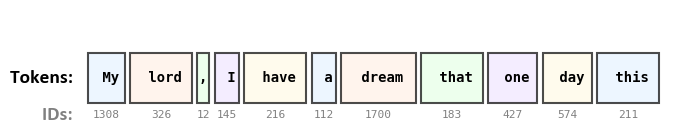

In [7]:
encode,decode, tokenizer, vocab_size = tokenize(text, vocab_size)

# check what it does
check_sentence = 'My lord, I have a dream that one day this nation will rise up!'
plot_sentence_tokens(check_sentence,tokenizer)


### Encode all text
Now encode the entire Shakespeare's text

In [13]:
data = torch.tensor(encode(text), dtype=torch.long)

Vocab size: 20000
 Gre ----> 3894
et ----> 165
ings ----> 519
, ----> 12
 My ----> 1308
 king ----> 734
! ----> 4
 ----> 3


### Training and Testing
I guess you are now familiar with the concept of training and testing. I wrote a simple function that splits the data into 90% training and 10% testing.

In [31]:
# split into training and testing
train_data, val_data = train_test_split(data, 0.9)
train_data, val_data = train_data.to(device), val_data.to(device)
print(f'Train size = {train_data.shape[0]} tokens ... Validation size = {val_data.shape[0]} tokens')

Train size = 1341850 tokens ... Validation size = 149100 tokens


### Creating and Training the Model
Now we want to build the model and some optimizing functions, and then train the model.

In [32]:
import os
model = BigramLanguageModel(vocab_size, n_embd, block_size, n_head, dropout, n_layer, device).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(max_iters=max_iters, warmup_steps=200))

# train the model
train_model(model, max_iters, eval_iters, train_data, val_data, batch_size,eval_interval, block_size,device,optimizer,scheduler)

base_dir = "/Users/abdelrahmansawalma/Downloads/LLMs"
model_name = f'model_batch{batch_size}_vocab{vocab_size}_nembed{n_embd}_block{block_size}_nhead{n_head}_n_layer{n_layer}'
model_path = os.path.join(base_dir,f'{model_name}.pt')
#save the model
torch.save(model.state_dict(), model_path)
print(f"Model saved as: {model_name}.pt")



step 0: train loss 10.0957, val loss 10.0986
step 1000: train loss 5.5660, val loss 5.8031
step 2000: train loss 5.2206, val loss 5.5287
step 3000: train loss 5.0201, val loss 5.3827
step 4000: train loss 4.8708, val loss 5.3296
step 5000: train loss 4.7575, val loss 5.3113
step 6000: train loss 4.6760, val loss 5.2831
step 7000: train loss 4.6066, val loss 5.2628
step 8000: train loss 4.5682, val loss 5.2673
step 9000: train loss 4.5689, val loss 5.2664
step 9999: train loss 4.5648, val loss 5.2629
Model saved as: model_batch32_vocab20000_nembed256_block256_nhead8_n_layer8.pt


In [12]:
model_url = "https://www.coreunitrdm.biozentrum.uni-wuerzburg.de/public.php/dav/files/G9NdHrd9F8wH39r/?accept=zip"


# Download the model file
def download_model(url, local_path="model.pth"):
    # Try direct download first
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(response.content)
        print(f"Model downloaded successfully as {local_path}")
        return local_path
    else:
        print(f"Download failed with status code: {response.status_code}")
        return None

# Download the model
local_model_path = download_model(model_url)

model = BigramLanguageModel(20000, 256, 256, 8, 0.1, 8, device)
model.load_state_dict(torch.load(local_model_path, map_location=device))
model = model.to(device)
model.eval()
print("Model loaded successfully!")



Model downloaded successfully as model.pth
Model loaded successfully!


In [ ]:
prompt = "To be, or not to be "
input_ids = torch.tensor([tokenizer.encode(prompt).ids], dtype=torch.long, device=device)
out = model.generate(idx=input_ids, max_new_tokens=200)
print(tokenizer.decode(out[0].tolist()))


In [24]:
import os
base_dir = "/Users/abdelrahmansawalma/Downloads/LLMs"
batch_size = 32
vocab_size = 20000
n_embd = 256
block_size = 256
n_head = 8
n_layer=8
encode,decode, tokenizer, vocab_size = tokenize(text, vocab_size)

model_name = f'model_batch{batch_size}_vocab{vocab_size}_nembed{n_embd}_block{block_size}_nhead{n_head}_n_layer{n_layer}'
model_path = os.path.join(base_dir,f'{model_name}.pt')


##load the model
model = BigramLanguageModel(vocab_size, n_embd, block_size, n_head, dropout, n_layer, device)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

prompt = "To be, or not to be "
input_ids = torch.tensor([tokenizer.encode(prompt).ids], dtype=torch.long, device=device)
out = model.generate(idx=input_ids, max_new_tokens=100)
print(tokenizer.decode(out[0].tolist()))




Vocab size: 20000
 To be, or not to be 8 to me ’)ke thrust they pl�Romans)ar hissght,��ott)Empaitingnter stirsThan Volumnius,��ott,� kindness th Cadwal we,Comoose we thame!��ott,�ThouThen hate they�asionsittleming lightning intents,� Step! succipe gHUMUS,��ANTUS,� hornsVERG vision,� passages CLOWN!��ott,� arllp wme mean to writeDEMETRIUSid,��ott,


5376417


---
### Sources:
[Introduction to Large Language Models](https://www.baeldung.com/cs/large-language-models)

[Youtube video about writing a GPT from scratch](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=2409s)